In [ ]:
# !pip install kagglehub
# 1. Download Kaggle InceptionV1 model
# import kagglehub
# model_path = kagglehub.model_download("google/inception-v1/tensorFlow2/feature-vector")

In [1]:
model_path = "C:/Users/Menna/.cache/kagglehub/models/google/inception-v1/tensorFlow2/feature-vector/2"

In [2]:
# 2. Configuration and Setup

import os
import random
import tensorflow as tf

BALANCED_DATASET_PATH = "dataset/VGGFace2_balanced_900_albumentations"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 15

c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runt

In [ ]:
# 3. Create dataset paths and shuffle
all_image_paths = [os.path.join(dp, f) # Create a list of full paths for all images in the dataset by walking through all folders and subfolders
                   for dp, dn, fn in os.walk(os.path.expanduser(BALANCED_DATASET_PATH)) 
                   for f in fn]

random.shuffle(all_image_paths)
total_images = len(all_image_paths)
print(f"Found {total_images} total images.")

# Split into train / val / test
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]
test_paths = all_image_paths[train_size + val_size:]

print(f"Training: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")


Found 13500 total images.
Training: 9450, Validation: 2025, Test: 2025


In [ ]:
# 4. Create tf.data.Dataset

# Extracts the folder names and map each class name to a unique integer
class_names = sorted([d for d in os.listdir(BALANCED_DATASET_PATH) if os.path.isdir(os.path.join(BALANCED_DATASET_PATH, d))])
class_to_int = {name: i for i, name in enumerate(class_names)} #Dictionary

def process_path(file_path):
    """Load image and label"""
    class_name = tf.strings.split(file_path, os.path.sep)[-2] # Extract the class name from paths & takes the second last element
    label = tf.py_function(lambda x: class_to_int[x.numpy().decode()], [class_name], tf.int32) # the value itself
    label.set_shape([]) # ensure that it is a scalar, not an array
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

def configure_for_performance(ds):
    # ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE) #Loads the next batch while the GPU is training on the current batch
    return ds

def configure_test(ds):
    # For testing: batch + prefetch only, no shuffle
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

#Converts a list of image file paths into a TensorFlow datase
train_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(train_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
val_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(val_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
test_ds = configure_test(tf.data.Dataset.from_tensor_slices(test_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))

print("Datasets ready ")


Datasets ready 


In [ ]:
# 5. Build Transfer Learning Model (Freeze base)

import tensorflow_hub as hub

# Data augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomContrast(0.1),
# ])

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),      
#     tf.keras.layers.RandomZoom(0.1),          
#     tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
#     tf.keras.layers.RandomContrast(0.2),      
#     tf.keras.layers.RandomBrightness(0.2),   
# ], name="data_augmentation")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.15),
    tf.keras.layers.RandomBrightness(0.15),
], name="data_augmentation")


inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)

# Wrap hub layer in Lambda to fix symbolic tensor issue
base_model = hub.KerasLayer(model_path, trainable=False, arguments=dict(batch_norm_momentum=0.997))
x = tf.keras.layers.Lambda(lambda z: base_model(z))(x)


# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # L2 Regularization: Prevents overfitting by keeping weights small
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs) 

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,255 (1.02 MB)

 Trainable params: 266,255 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Because  base model is wrapped inside a Lambda layer, Keras cannot inspect its weights
# This is a limitation of Lambda; it does not mean the base model is trainable
#--------------------------------------
# Note: Non-trainable params show 0 because the base_model is wrapped in a Lambda layer
# Actual base_model weights are frozen, but summary cannot display them inside Lambda

In [ ]:
# --- Train the model ---
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'inception_v1_transfer_ver41.keras',  
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1 # prints a message whenever a new best model is saved
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True, # loads the best model weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
# history_test = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=7,
#     callbacks=[]  # Pass an empty list to disable callbacks
# )

Epoch 1/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 114s 367ms/step - accuracy: 0.2803 - loss: 2.2868 - val_accuracy: 0.4677 - val_loss: 1.8205
Epoch 2/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 324ms/step - accuracy: 0.4154 - loss: 1.8199 - val_accuracy: 0.5388 - val_loss: 1.5565
Epoch 3/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 322ms/step - accuracy: 0.4694 - loss: 1.6456 - val_accuracy: 0.4879 - val_loss: 1.5373
Epoch 4/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 325ms/step - accuracy: 0.4950 - loss: 1.5790 - val_accuracy: 0.5565 - val_loss: 1.4336
Epoch 5/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 325ms/step - accuracy: 0.5229 - loss: 1.5104 - val_accuracy: 0.5773 - val_loss: 1.3632
Epoch 6/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 97s 326ms/step - accuracy: 0.5278 - loss: 1.4904 - val_accuracy: 0.6217 - val_loss: 1.3294
Epoch 7/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 99s 335ms/step - accuracy: 0.5376 - loss: 1.4642 - val_accuracy: 0.5728 - val_loss: 1.3722


In [18]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)



Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.1881 - loss: 2.3506
Epoch 1: val_accuracy improved from None to 0.43506, saving model to inception_v1_transfer_ver41.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 104s 331ms/step - accuracy: 0.2530 - loss: 2.1184 - val_accuracy: 0.4351 - val_loss: 1.7143 - learning_rate: 3.0000e-04
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.3730 - loss: 1.7653
Epoch 2: val_accuracy improved from 0.43506 to 0.54272, saving model to inception_v1_transfer_ver41.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 323ms/step - accuracy: 0.4010 - loss: 1.7139 - val_accuracy: 0.5427 - val_loss: 1.4642 - learning_rate: 3.0000e-04
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4639 - loss: 1.5644
Epoch 3: val_accuracy improved from 0.54272 to 0.56988, saving model to inception_v1_transfer_ver41.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 98s 330ms/step - accuracy: 0.4815 - loss: 1.5261 - val_accuracy: 0.5699 - val_loss: 1.3499 -

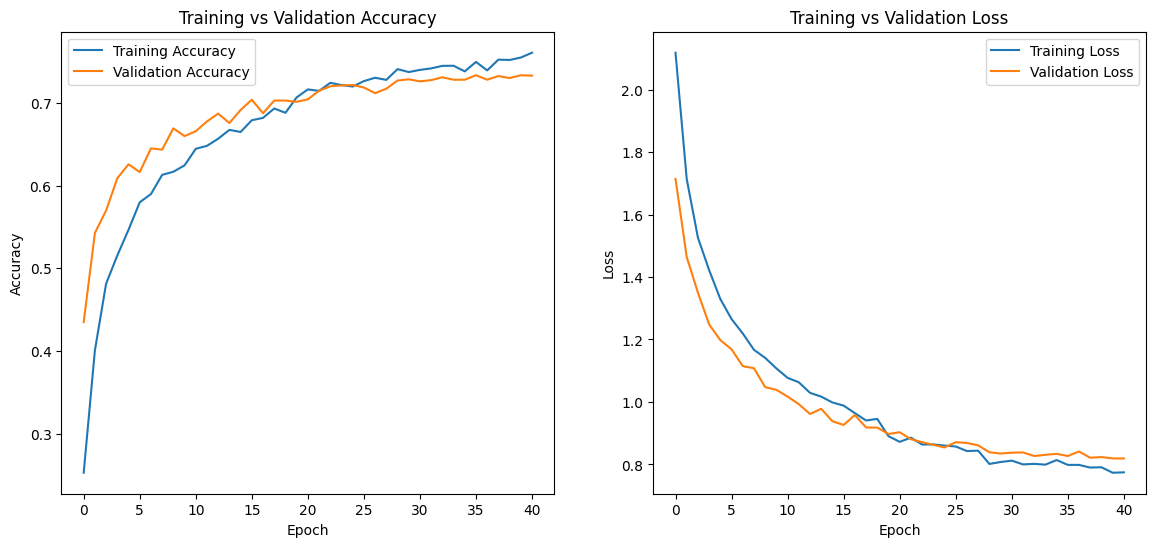

In [19]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Fine tune

In [22]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint,]
)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7608 - loss: 0.7585
Epoch 1: val_accuracy did not improve from 0.73333
296/296 ━━━━━━━━━━━━━━━━━━━━ 105s 336ms/step - accuracy: 0.7548 - loss: 0.7731 - val_accuracy: 0.7279 - val_loss: 0.8250
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7553 - loss: 0.7850
Epoch 2: val_accuracy did not improve from 0.73333
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 324ms/step - accuracy: 0.7548 - loss: 0.7890 - val_accuracy: 0.7279 - val_loss: 0.8241
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7536 - loss: 0.7845
Epoch 3: val_accuracy did not improve from 0.73333
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 324ms/step - accuracy: 0.7575 - loss: 0.7738 - val_accuracy: 0.7274 - val_loss: 0.8233
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7636 - loss: 0.7628
Epoch 4: val_accuracy did not improve from 0.73333
296/296 ━━━━━━━━━━━━━━━━━━━━ 98s 330ms/step - accuracy: 0.7571 - loss: 0.7755 - val

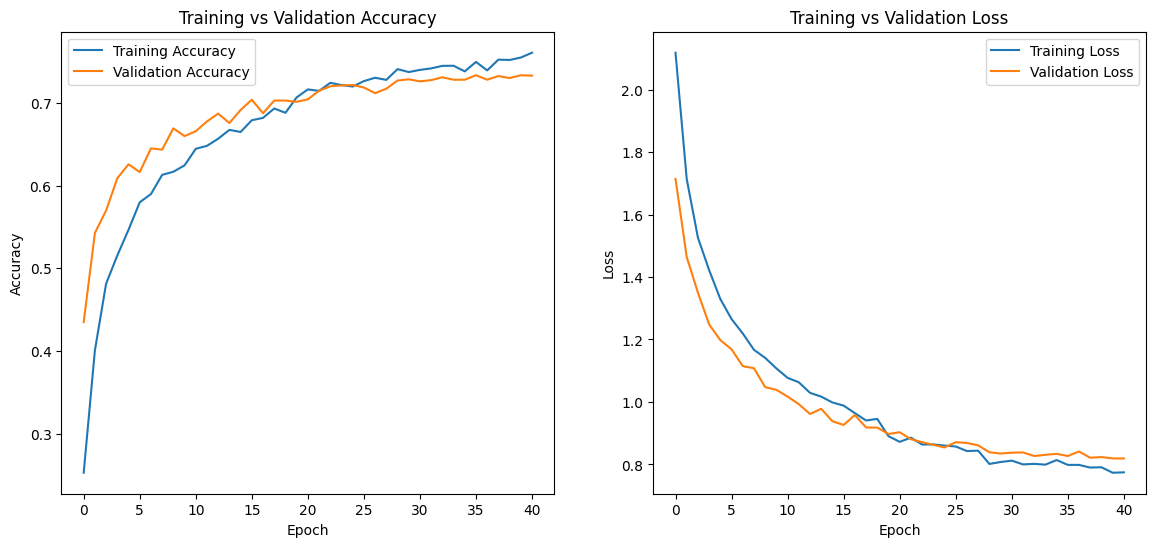

In [23]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [25]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.7496 - loss: 0.8142
Test Accuracy: 74.96%
Test Loss: 0.8142


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import tensorflow as tf


y_true = []
y_prob = []  
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images)           
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy().astype(int).tolist())
    y_pred.extend(preds.tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)   


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Accuracy: 0.7496

Classification Report:

                          precision    recall  f1-score   support

        Aditi Rao Hydari     0.6901    0.7903    0.7368       124
Adrienne Bailon-Houghton     0.5359    0.6721    0.5964       122
    Alberto Núñez Feijóo     0.8129    0.7847    0.7986       144
  Aleksander Kwaśniewski     0.8320    0.8000    0.8157       130
  Aleksandra Kwaśniewska     0.7105    0.5062    0.5912       160
            Alesha Dixon     0.6719    0.6099    0.6394       141
            Alex Salmond     0.7818    0.8269    0.8037       104
             Alexa Chung     0.7294    0.8267    0.7750       150
 Alfredo Pérez Rubalcaba     0.8811    0.9197    0.9000       137
          Aléxis Tsípras     0.8496    0.8014    0.8248       141
             Amber Heard     0.6667    0.6842    0.6753       152
               Amy Adams     0.6614    0.6720    0.6667       125
         Andie MacDowell     0.8000    0.7000    0.7467       120
             Boris Tadić     0.83

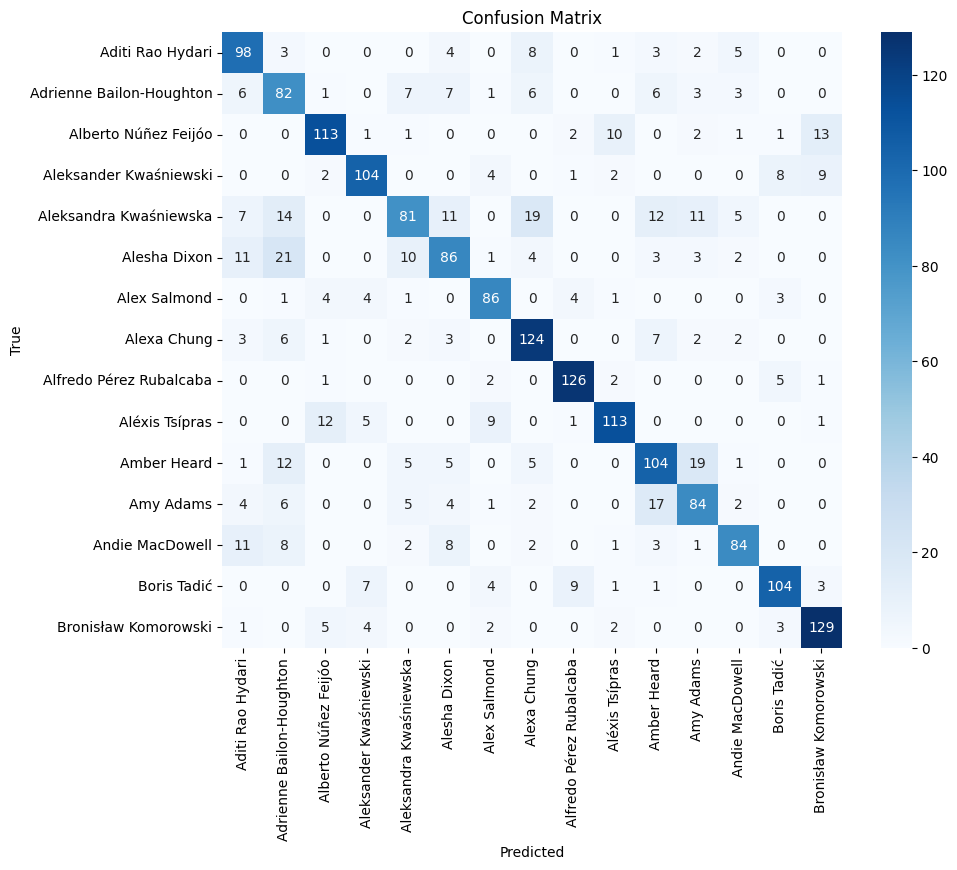

In [29]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

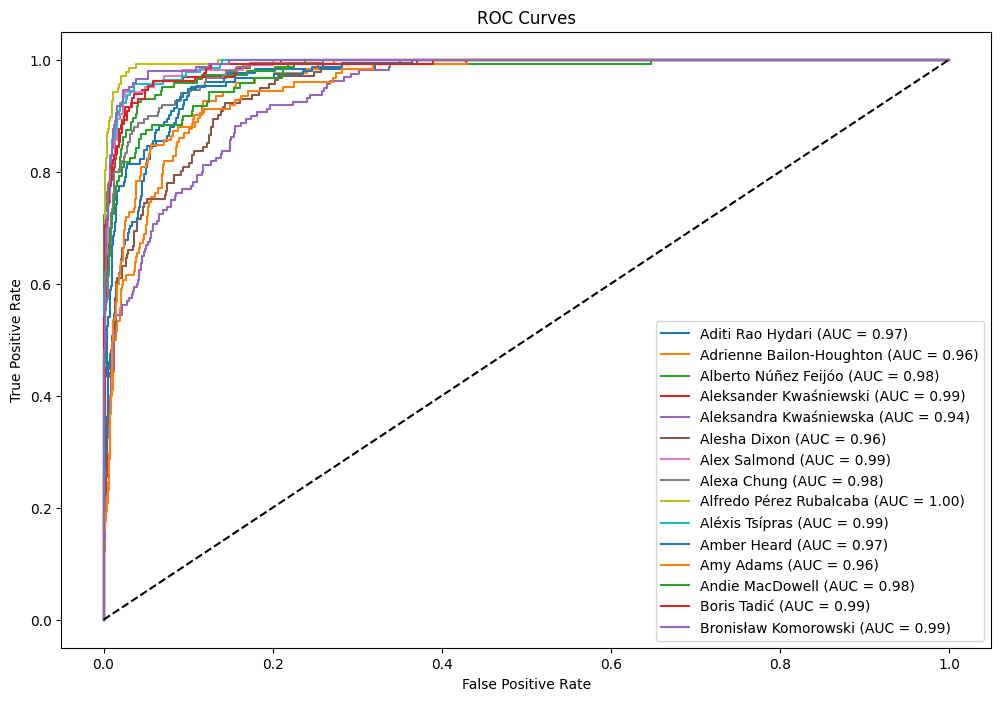

In [30]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
